In [59]:
from enum import Enum
import random
import math
import numpy as np
import time as time
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

class Action(Enum):
    STICK = 0
    HIT = 1
    def __int__(self):
        return self.value
    
class Environment:
    def __init__(self):
        self.cards = [-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,1,2,3,4,5,6,7,8,9]
    def generate_random_card(self):
        return random.choice(self.cards)
    def step(self, s, a):
        s_prim = dict()
        if a == Action.STICK:
            s_prim['ds'] = s['ds']
            new_card = self.generate_random_card()
            s_prim['ps'] = s['ps'] + new_card
            if s_prim['ps'] < 1 or s_prim['ps'] > 21:
                s_prim['terminal'] = True
                s_prim['reward'] = -1
            else:
                s_prim['terminal'] = False
                s_prim['reward'] = 0
            return s_prim
        else:
            s_prim = dict()
            s_prim['ds'] = s['ds']
            s_prim['ps'] = s['ps']
            while s_prim['ds'] <= 17:
                new_card = self.generate_random_card()
                new_sum = s_prim['ds'] + new_card
                s_prim['ds'] = new_sum
                if s_prim['ds'] < 1 or s_prim['ds'] > 21:
                    s_prim['terminal'] = True
                    s_prim['reward'] = 1
                    return s_prim
            s_prim['terminal'] = True
            if s['ps'] > s_prim['ds']:
                s_prim['reward'] = 1
            elif s['ps'] < s_prim['ds']:
                s_prim['reward'] = -1
            else:
                s_prim['reward'] = 0
            return s_prim
def plot(Q):
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Make data.
    X = np.arange(0, Q.shape[0], 1)
    Y = np.arange(0, Q.shape[1], 1)
    X, Y = np.meshgrid(X, Y)
    V = np.max(Q,axis=2)
    Z = V[X,Y]

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    #plt.savefig('easy21_sarsa_lambda.png', dpi=300)
    plt.show()

In [22]:
class MonteCarloControl:
    def __init__(self):
        self.Q = np.random.rand(10,21,2)
        self.N_s = np.zeros((10,21))
        self.N_sa = np.zeros((10,21,2))
        self.N_zero = 100
        self.env = Environment()
    def train(self, num_episodes):
        for i in tqdm(range(0,num_episodes)):
            episode = []
            s = dict()
            s['ds'] = random.randint(1,10)
            s['ps'] = random.randint(1,21)
            s['terminal'] = False

            self.N_s[s['ds']-1, s['ps']-1] += 1

            # generate episode
            while s['terminal'] == False:
                # epsilon-greedy policy
                eps = self.N_zero/(self.N_zero+self.N_s[s['ds']-1,s['ps']-1])
                if random.random() < 1-eps:    
                    p = np.argmax(self.Q[s['ds']-1,s['ps']-1])
                else:
                    p = random.choice([0,1])

                if p == 0:
                    a = Action.STICK
                    self.N_sa[s['ds']-1,s['ps']-1,0]+=1
                    episode.append([s,a])
                    s = self.env.step(s,a)
                elif p == 1:
                    a = Action.HIT
                    self.N_sa[s['ds']-1,s['ps']-1,1]+=1
                    episode.append([s,a])
                    s = self.env.step(s,a)
                else:
                    print('p is not 0 or 1')
                    break
                if s['terminal'] == False:
                    self.N_s[s['ds']-1, s['ps']-1] += 1                    
            #update Q
            reward = s['reward']
            for sa in episode:
                state = sa[0]
                action = int(sa[1])
                self.Q[state['ds']-1, state['ps']-1,action] += 1/self.N_sa[state['ds']-1, state['ps']-1,action] * (reward-self.Q[state['ds']-1, state['ps']-1,action])

100%|██████████| 1000000/1000000 [00:16<00:00, 62239.42it/s]


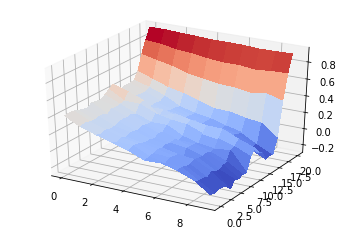

In [23]:
mcc = MonteCarloControl()
mcc.train(int(1e6))
plot(mcc.Q)

In [52]:
class SarsaLambda:
    def __init__(self):
        self.Q = np.zeros((10,21,2))
        self.N_s = np.zeros((10,21))
        self.N_sa = np.zeros((10,21,2))
        self.N_zero = 100
        self.gamma = 1.0
        self.lamb = 1.0
        self.env = Environment()
    def train(self, num_episodes):
        for i in tqdm(range(0,num_episodes)):
            E = np.zeros((10,21,2))
            s = dict()
            s['ds'] = random.randint(1,10)
            s['ps'] = random.randint(1,21)
            s['terminal'] = False
            s['reward'] = 0
            self.N_s[s['ds']-1, s['ps']-1] += 1

            eps = self.N_zero/(self.N_zero+self.N_s[s['ds']-1,s['ps']-1])
            if random.random() < 1-eps:
                p = np.argmax(self.Q[s['ds']-1,s['ps']-1])
            else:
                p = random.choice([0,1])
            if p == 0:
                a = Action.STICK
            else:
                a = Action.HIT
            self.N_sa[s['ds']-1, s['ps']-1, int(a)] += 1

            # generate episode
            while s['terminal'] == False:
                s_prim = self.env.step(s,a)
                self.N_sa[s['ds']-1, s['ps']-1, int(a)] += 1
                alpha = 1.0/self.N_sa[s['ds']-1,s['ps']-1,int(a)]

                if s_prim['terminal'] == False:
                    self.N_s[s_prim['ds']-1, s_prim['ps']-1] += 1
                    eps = self.N_zero/(self.N_zero+self.N_s[s['ds']-1,s['ps']-1])
                    if random.random() < 1-eps:      
                        p = np.argmax(self.Q[s_prim['ds']-1,s_prim['ps']-1])
                    else:
                        p = random.choice([0,1])
                    if p == 0:
                        a_prim = Action.STICK
                    else:
                        a_prim = Action.HIT
                    delta = s_prim['reward'] + self.gamma*self.Q[s_prim['ds']-1, s_prim['ps']-1, int(a_prim)] - self.Q[s['ds']-1, s['ps']-1, int(a)]
                    E[s['ds']-1, s['ps']-1, int(a)] += 1
                    self.Q += alpha*delta*E
                    E *= self.gamma*self.lamb
                    s = s_prim
                    a = a_prim
                else:
                    delta = s_prim['reward'] - self.Q[s['ds']-1, s['ps']-1, int(a)]
                    E[s['ds']-1, s['ps']-1, int(a)] += 1
                    self.Q += alpha*delta*E
                    E *= self.gamma*self.lamb
                    s = s_prim

100%|██████████| 10000000/10000000 [04:47<00:00, 34781.84it/s]


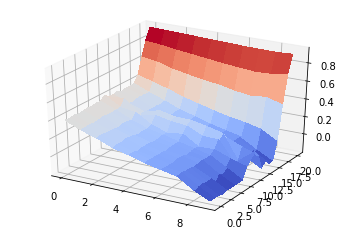

In [54]:
sarsa = SarsaLambda()
sarsa.train(int(1e7))
plot(sarsa.Q)